# Facebook Prophet

**Papaer for Prophet! It is relatively straightforward and has a lot of insight on their techniques on how Prophet works internally!**
Link to paper: https://peerj.com/preprints/3190.pdf

FbProphet is a powerful time series analysis package released by Core Data Science Team at Facebook. It is simple and easy to go package for performing time series analytics and forecasting at scale.


<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/prophet.png" width="1200">

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.



#### Accurate and fast.
Prophet is used in many applications across Facebook for producing reliable forecasts for planning and goal setting. We’ve found it to perform better than any other approach in the majority of cases. We fit models in Stan so that you get forecasts in just a few seconds.

#### Fully automatic.
Get a reasonable forecast on messy data with no manual effort. Prophet is robust to outliers, missing data, and dramatic changes in your time series.

#### Tunable forecasts.
The Prophet procedure includes many possibilities for users to tweak and adjust forecasts. You can use human-interpretable parameters to improve your forecast by adding your domain knowledge.

## The Prophet Forecasting Model

Prophet was developed by Facebook and released as open source in 2017: [https://facebook.github.io/prophet/]

The library utilizes the [additive regression model](https://en.wikipedia.org/wiki/Additive_model) $y(t)$ comprising the following components:

$$y(t) = g(t) + s(t) + h(t) + \epsilon(t)$$

where:
* Trend $g(t)$ models non-periodic changes : __piecewise linear__ or __logistic growth__ curve for modelling non-periodic changes in time series
* Seasonality $s(t)$ represents periodic changes (e.g. weekly/yearly seasonality)
* Holidays component $h(t)$ contributes information about holidays and events effects of holidays (user provided) with irregular schedules.

 
### Trend

The Prophet library implements two possible trend models for $g(t)$.

- *Nonlinear, Saturating Growth*. It is represented in the form of the [logistic growth model](https://en.wikipedia.org/wiki/Logistic_function):

$$g(t) = \frac{C}{1+e^{-k(t - m)}},$$

- *Piecewise Linear Model* with a constant rate of growth. It is best suited for problems without saturating growth.

### Seasonality

The seasonal component $s(t)$ provides a flexible model of periodic changes due to daily weekly and yearly seasonality. Prophet relies on Fourier series to model seasonality:
* A **higher order** fits the sine wave more closely to the seasonality in the data, at the risk of capturing too much of the noise __overfitting__
* A **lower order** smoothes out the noise, at the risk of not capturing enough of the seasonality __underfitting__

A good, general fit lies in between: try to find this by Prophet's built-in cross-validation method.
 
 

### Holidays and Events

The component $h(t)$ represents predictable abnormal days of the year including those on irregular schedules, e.g., Black Fridays.


### Error

The error term $\epsilon(t)$ represents information that was not reflected in the model. Usually it is modeled as normally distributed noise.

In [1]:
import pandas as pd
from prophet import Prophet

## Load Data

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [ ]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/BeerWineLiquor.csv

--2022-11-29 14:51:14--  https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/BeerWineLiquor.csv
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.144.26
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.144.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4627 (4.5K) [text/csv]
Saving to: ‘BeerWineLiquor.csv.1’

BeerWineLiquor.csv. 100%[===================>]   4.52K  --.-KB/s    in 0s      

2022-11-29 14:51:14 (72.6 MB/s) - ‘BeerWineLiquor.csv.1’ saved [4627/4627]



In [2]:
df = pd.read_csv('BeerWineLiquor.csv')
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    324 non-null    datetime64[ns]
 1   beer    324 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.2 KB


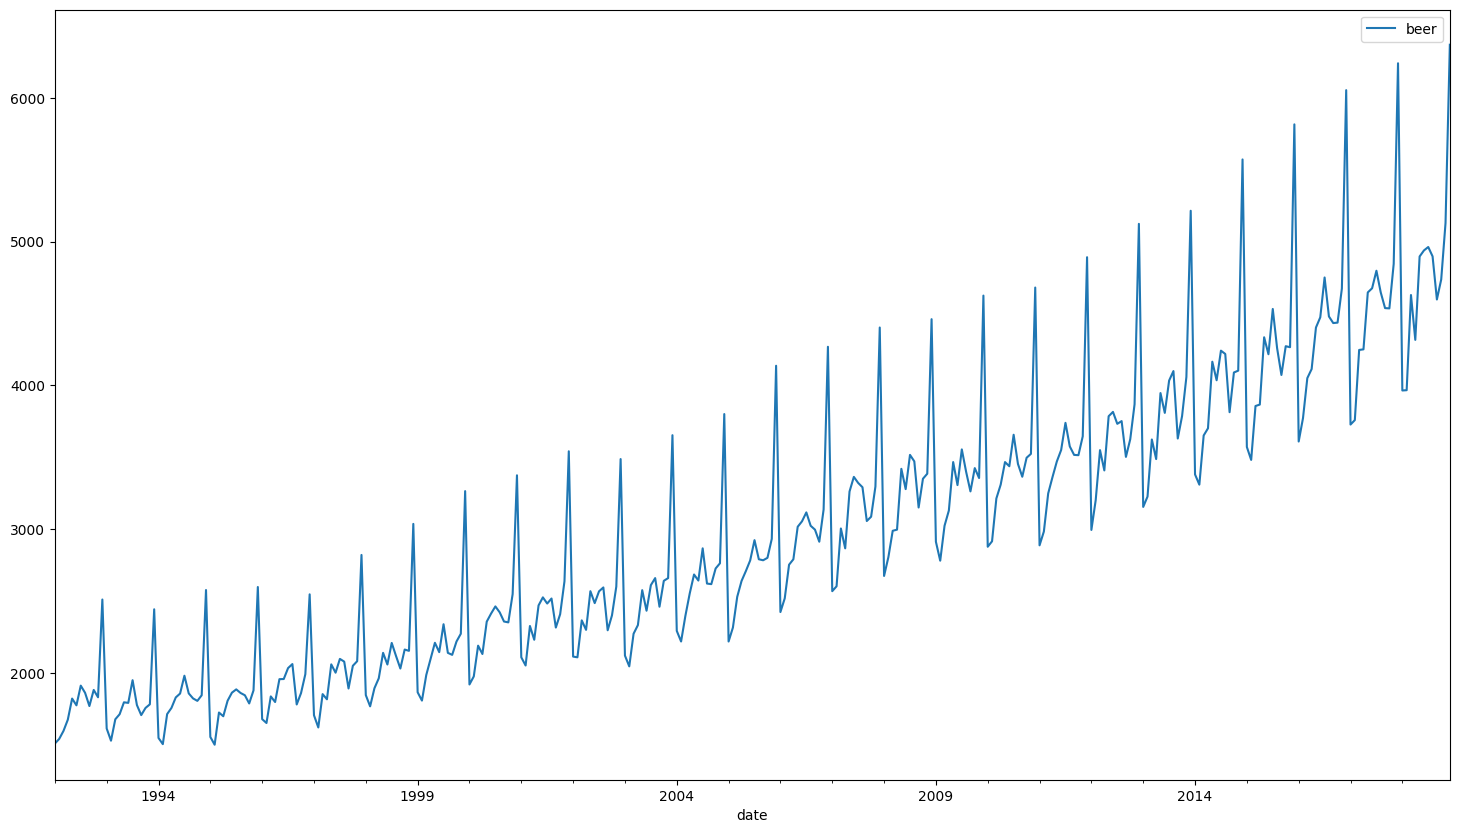

In [3]:
df.plot(x='date',y='beer',figsize=(18,10));

### Format the Data for PROPHET STANDARD

In [4]:
## OBBLIGO!!!
df.columns = ['ds','y']

In [5]:
df['ds'] = pd.to_datetime(df['ds'])

In [6]:
df

,ds,y
0,1992-01-01,1509
1,1992-02-01,1541
2,1992-03-01,1597
3,1992-04-01,1675
4,1992-05-01,1822
...,...,...
319,2018-08-01,4898
320,2018-09-01,4598
321,2018-10-01,4737
322,2018-11-01,5130


## Create and Fit Model

In [7]:
# This is fitting on all the data (no train test split in this example)
m = Prophet()
model = m.fit(df)

20:28:40 - cmdstanpy - INFO - Chain [1] start processing
20:28:40 - cmdstanpy - INFO - Chain [1] done processing


## Forecasting

### Step 1: Create "future" placeholder dataframe

**NOTE: Prophet by default is for daily data. You need to pass a frequency for sub-daily or monthly data. Info: https://facebook.github.io/prophet/docs/non-daily_data.html**

In [8]:
future = model.make_future_dataframe(periods=24,freq = 'MS')

In [10]:
df.tail()

,ds,y
319,2018-08-01,4898
320,2018-09-01,4598
321,2018-10-01,4737
322,2018-11-01,5130
323,2018-12-01,6370


In [11]:
future.head()

,ds
0,1992-01-01
1,1992-02-01
2,1992-03-01
3,1992-04-01
4,1992-05-01


In [12]:
future.tail()

,ds
343,2020-08-01
344,2020-09-01
345,2020-10-01
346,2020-11-01
347,2020-12-01


In [ ]:
len(df)

324

In [ ]:
len(future) # 324 past +24 forecast future

348


### Step 2: Predict and fill in the Future

In [15]:
forecast = model.predict(future)

In [16]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1992-01-01,1772.898400,1144.365197,1478.425111,1772.898400,1772.898400,-461.854666,-461.854666,-461.854666,-461.854666,-461.854666,-461.854666,0.0,0.0,0.0,1311.043734
1,1992-02-01,1775.730691,1200.590278,1505.164863,1775.730691,1775.730691,-427.558972,-427.558972,-427.558972,-427.558972,-427.558972,-427.558972,0.0,0.0,0.0,1348.171720
2,1992-03-01,1778.380254,1441.071674,1754.781398,1778.380254,1778.380254,-179.202384,-179.202384,-179.202384,-179.202384,-179.202384,-179.202384,0.0,0.0,0.0,1599.177870
3,1992-04-01,1781.212546,1415.789635,1754.810085,1781.212546,1781.212546,-196.248666,-196.248666,-196.248666,-196.248666,-196.248666,-196.248666,0.0,0.0,0.0,1584.963880
4,1992-05-01,1783.953473,1669.023794,1985.764680,1783.953473,1783.953473,45.147907,45.147907,45.147907,45.147907,45.147907,45.147907,0.0,0.0,0.0,1829.101380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,2020-08-01,5200.713315,5071.105297,5400.770671,5188.435200,5213.081926,40.246355,40.246355,40.246355,40.246355,40.246355,40.246355,0.0,0.0,0.0,5240.959670
344,2020-09-01,5216.783409,4926.145928,5241.046718,5203.483760,5230.604346,-132.916603,-132.916603,-132.916603,-132.916603,-132.916603,-132.916603,0.0,0.0,0.0,5083.866806
345,2020-10-01,5232.335113,5029.677110,5358.627853,5217.761386,5247.353197,-43.289567,-43.289567,-43.289567,-43.289567,-43.289567,-43.289567,0.0,0.0,0.0,5189.045546
346,2020-11-01,5248.405207,5176.206265,5492.187765,5232.892061,5264.671725,86.826365,86.826365,86.826365,86.826365,86.826365,86.826365,0.0,0.0,0.0,5335.231572


In [17]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [18]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(25)

,ds,yhat,yhat_lower,yhat_upper
323,2018-12-01,5989.180646,5824.489889,6156.757543
324,2019-01-01,4444.480167,4281.539696,4605.957714
325,2019-02-01,4469.105033,4307.621416,4621.695042
326,2019-03-01,4710.325650,4547.007741,4869.053754
327,2019-04-01,4733.170624,4561.207931,4886.594236
328,2019-05-01,5004.363552,4852.021948,5172.172410
329,2019-06-01,4993.686221,4841.531950,5157.862740
330,2019-07-01,5139.539167,4966.163145,5311.225178
331,2019-08-01,5047.888547,4892.047554,5197.105204
332,2019-09-01,4907.717395,4740.901749,5068.618426


### Plotting Forecast

We can use Prophet's own built in plotting tools

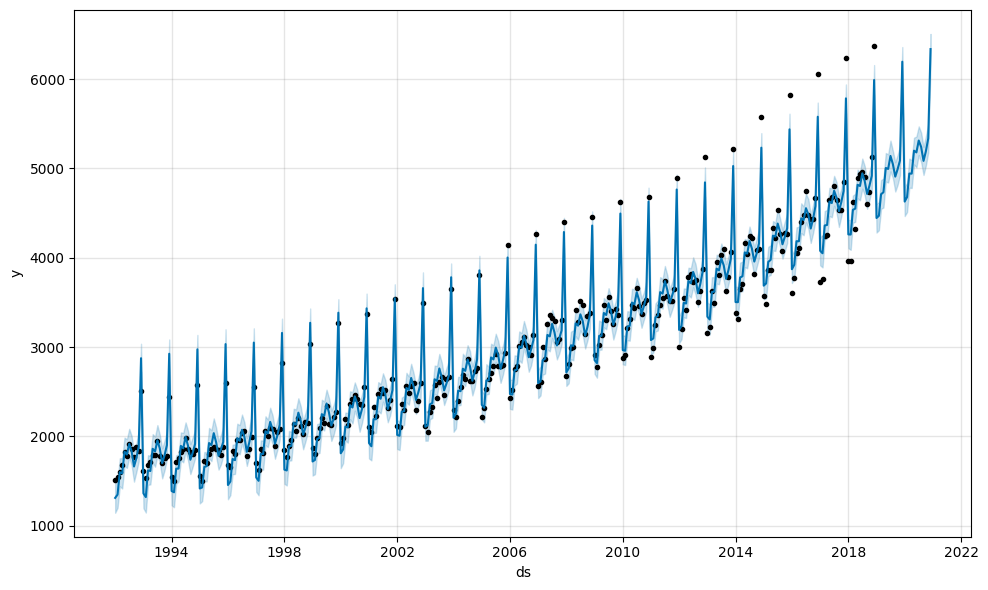

In [19]:
model.plot(forecast);

(528.0, 600.0)

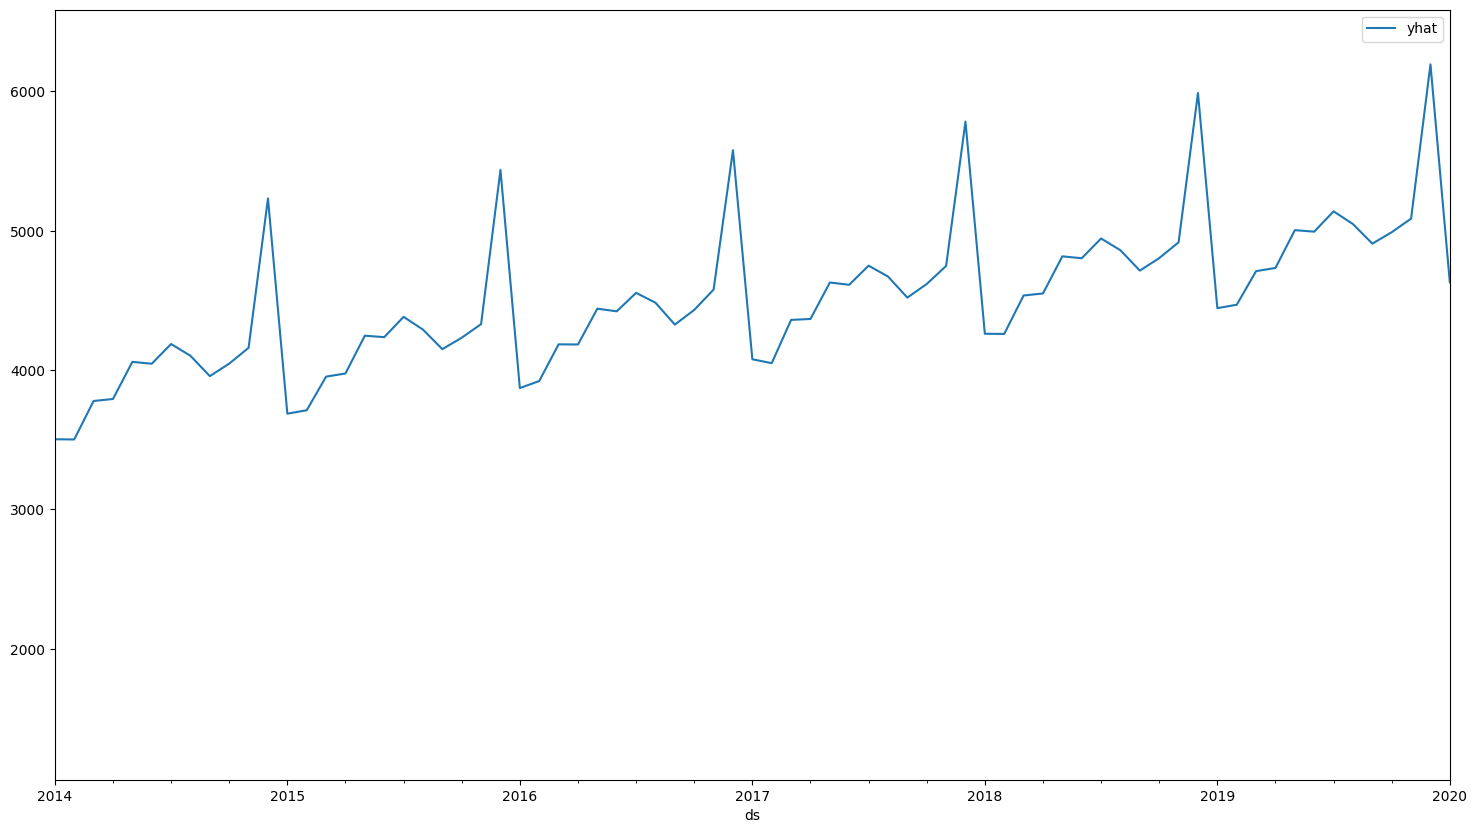

In [20]:
import matplotlib.pyplot as plt

forecast.plot(x='ds',y='yhat',figsize=(18,10))

plt.xlim('2014-01-01','2020-01-01')

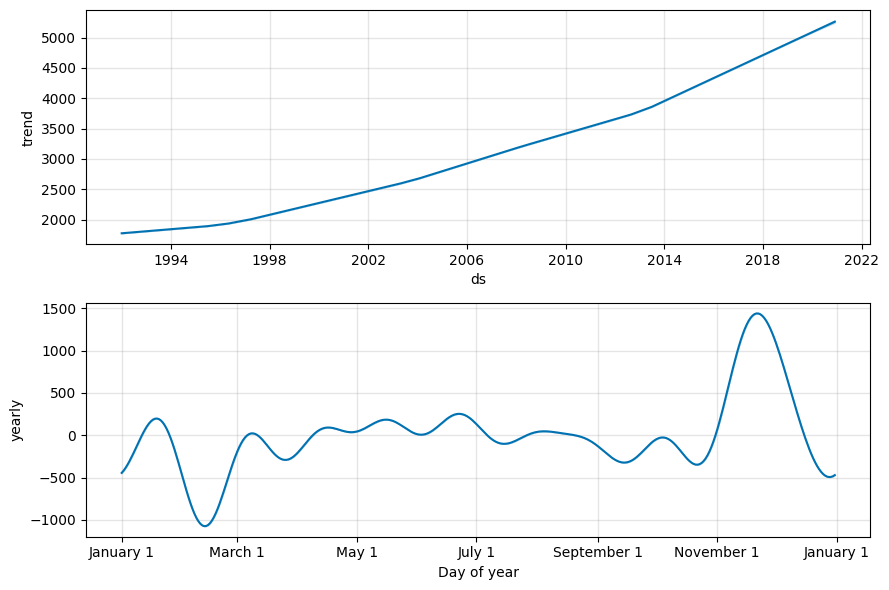

In [21]:
model.plot_components(forecast);

## Changing Seasonality with Prophet


In [22]:
import pandas as pd
from prophet import Prophet

%matplotlib inline

In [ ]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/timeseries/Data/airline_passengers.csv

--2022-11-29 14:51:22--  https://frenzy86.s3.eu-west-2.amazonaws.com/timeseries/Data/airline_passengers.csv
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 3.5.245.169
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|3.5.245.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2049 (2.0K) [application/vnd.ms-excel]
Saving to: ‘airline_passengers.csv.1’

airline_passengers. 100%[===================>]   2.00K  --.-KB/s    in 0s      

2022-11-29 14:51:23 (24.1 MB/s) - ‘airline_passengers.csv.1’ saved [2049/2049]



In [23]:
df = pd.read_csv('airline_passengers.csv')
df

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [24]:
df.columns = ['ds','y']
df['ds'] = pd.to_datetime(df['ds'])

20:39:34 - cmdstanpy - INFO - Chain [1] start processing
20:39:34 - cmdstanpy - INFO - Chain [1] done processing


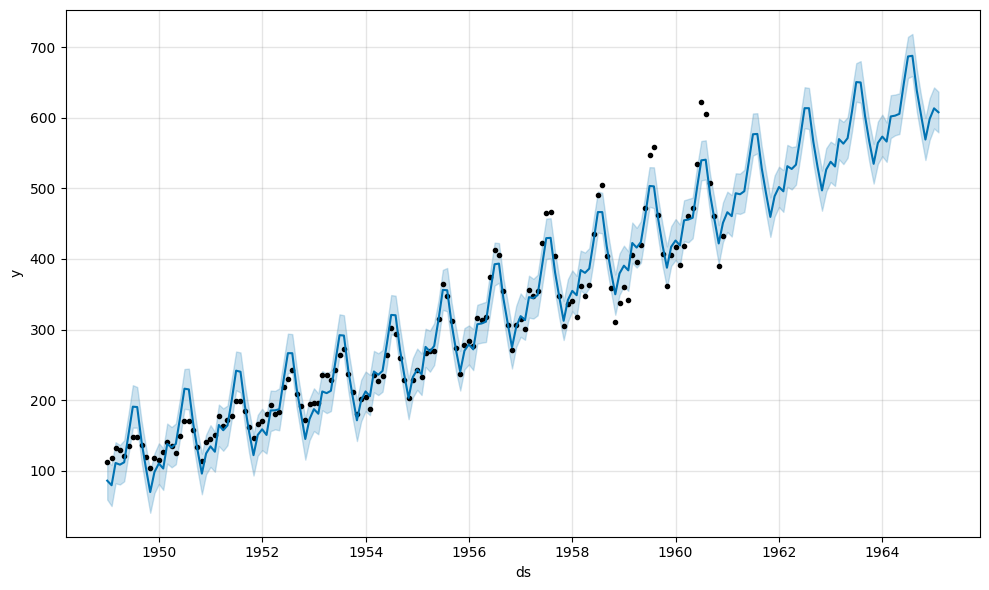

In [25]:
m = Prophet()
model = m.fit(df)
future = model.make_future_dataframe(50, freq='MS')
forecast = model.predict(future)

fig = model.plot(forecast)

This time series has a clear yearly cycle, but the seasonality in the forecast is too large at the start of the time series and too small at the end. In this time series, the seasonality is not a constant additive factor as assumed by Prophet, rather it grows with the trend. This is multiplicative seasonality.

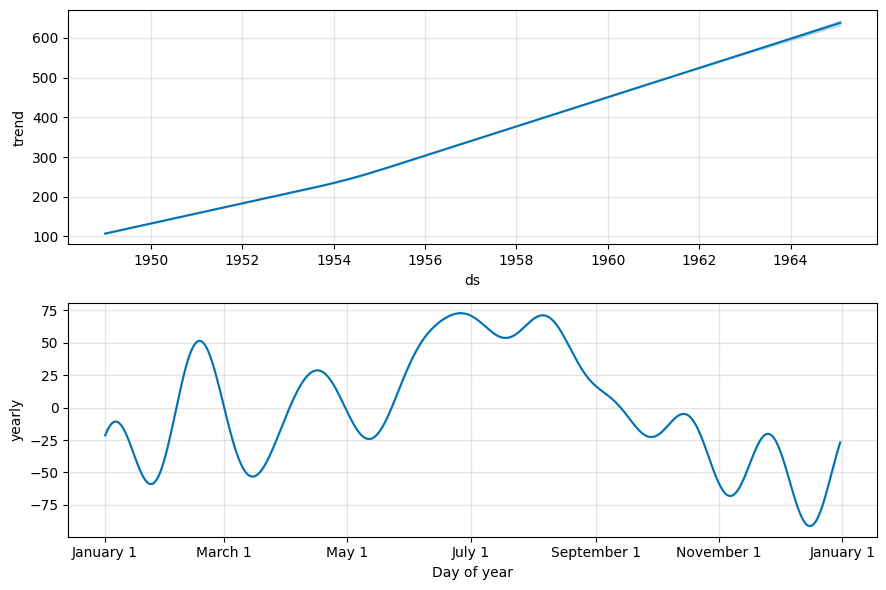

In [26]:
fig = model.plot_components(forecast)

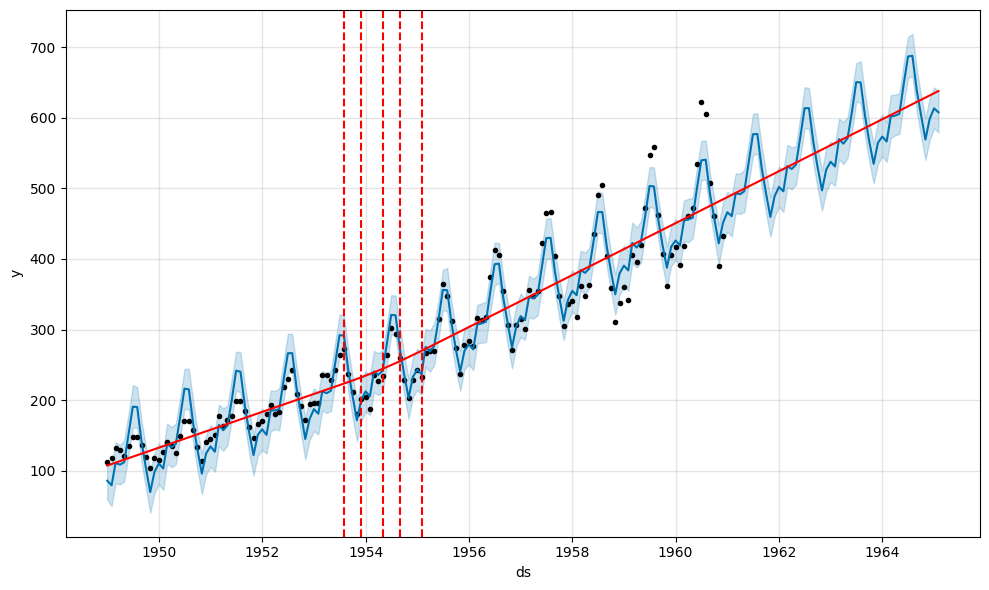

In [27]:
from prophet.plot import add_changepoints_to_plot

fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

### Change to Multiplicative 

20:41:22 - cmdstanpy - INFO - Chain [1] start processing
20:41:22 - cmdstanpy - INFO - Chain [1] done processing


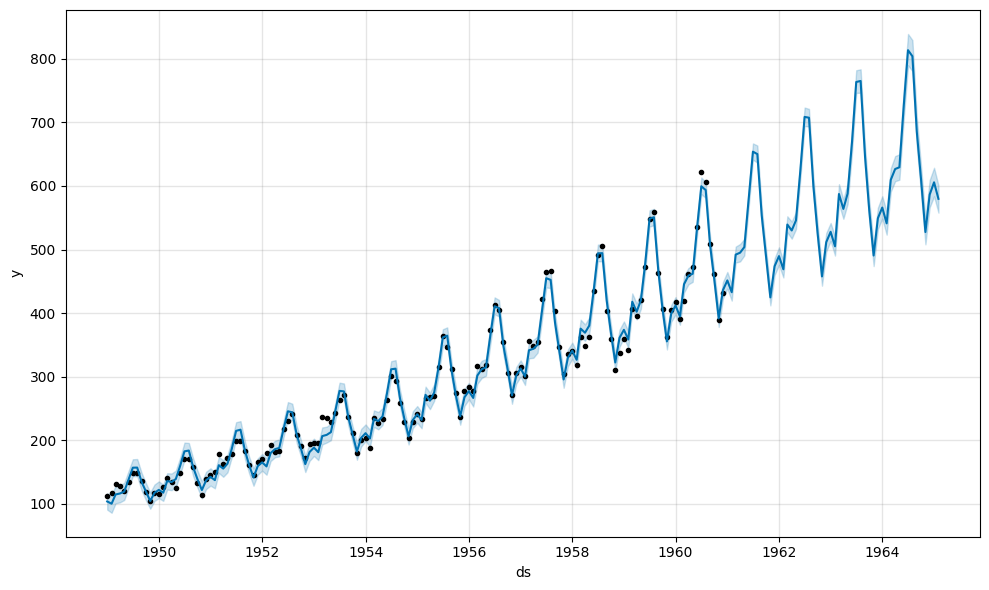

In [28]:
m = Prophet(seasonality_mode='multiplicative')
model = m.fit(df)
forecast = model.predict(future)
fig = model.plot(forecast)

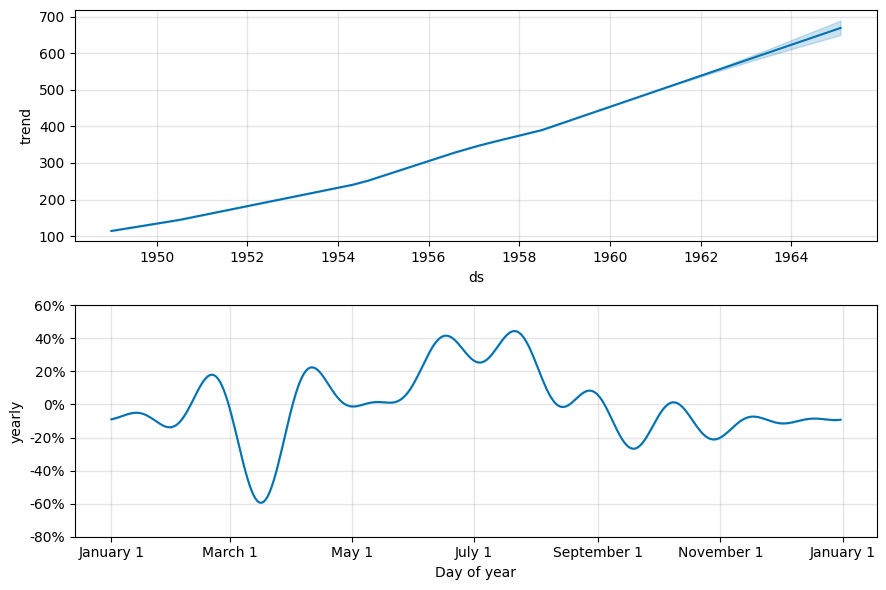

In [29]:
fig = model.plot_components(forecast)

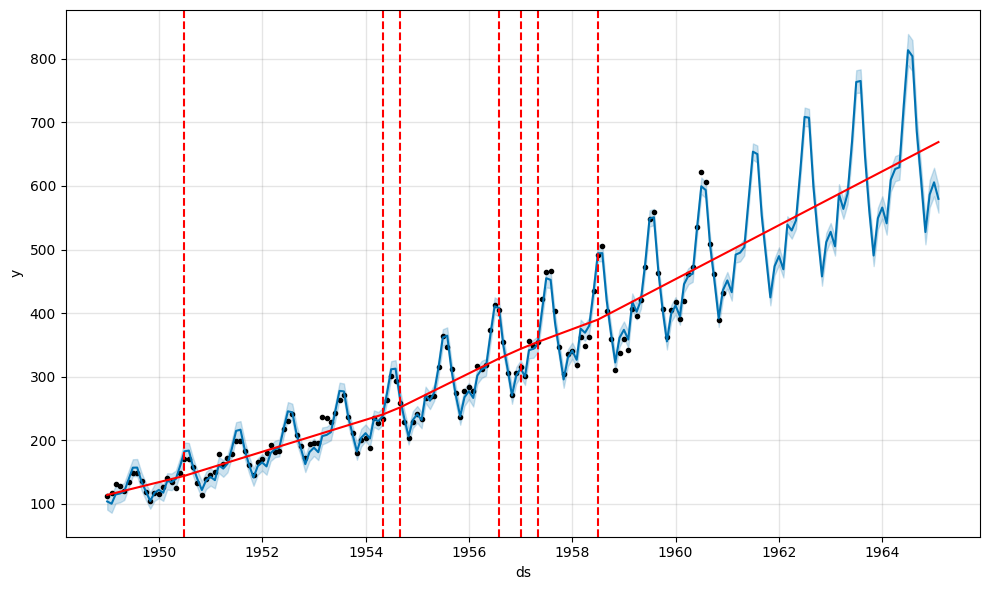

In [30]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [31]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error

df_merge = pd.merge(df, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge.tail()

,ds,yhat_lower,yhat_upper,yhat,y
139,1960-08-01,581.093901,606.211273,593.618536,606
140,1960-09-01,494.499039,520.907085,507.044302,508
141,1960-10-01,440.136764,464.798185,452.554715,461
142,1960-11-01,378.297994,405.335158,391.794943,390
143,1960-12-01,423.225382,449.087142,436.230373,432


In [32]:
# calculate MAE between observed and predicted values 
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values

mae_01 = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae_01)

mse_01 = mean_squared_error(y_true, y_pred)
print('MSE: %.3f' % mse_01)

mape_01 = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: %.3f' % mape_01)

MAE: 7.848
MSE: 104.226
MAPE: 0.033
